# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [2]:
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multinomial

In [3]:
corrector_mode=False  #False for me, and true to leave how it was written before to load a dataset

In [4]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.mu = norm.fit(X)[0]
        if norm.fit(X)[1] == 0:
            self.sigma = 1e-6
        else:
            self.sigma = norm.fit(X)[1]
        
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        return norm.logpdf(X_new, loc=self.mu, scale=self.sigma)
    
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # X is a vector with binary values
        
        self.p = (sum(X) + ALPHA)/(len(X) + ALPHA)
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        return bernoulli.logpmf(X_new, self.p)
    
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        values, counts = np.unique(X, return_counts=True)
        #label_ranges = np.arange(values.min(), values.max()+1)
        label_ranges = np.arange(0, self._num_of_categories)
        counts = np.zeros(label_ranges.shape)
        for value in label_ranges:
          counts[value] = np.count_nonzero(X == value)
        
        self.p = (counts + ALPHA)/(len(X) + self._num_of_categories* ALPHA)
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self._X_new = np.zeros((X_new.shape[0], self._num_of_categories))
        for x_value, index in zip(X_new, np.arange(0, X_new.shape[0])) :
          #print('x_value,index:',x_value,index)
          self._X_new[index, x_value] = 1
        return multinomial.logpmf(self._X_new, n=1, p=self.p)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [5]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [6]:
param.mu
param.sigma

0.9818925482223455

In [7]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])
#X = np.array([0,0,0,0,0,0,0,0,0,0])
#X = np.array([1,1,1,1,1,1,1,1,1,1])
param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-1.01160091 -0.45198512]


In [8]:
param.p

0.6363636363636364

In [9]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


In [10]:
param.p

array([0.14285714, 0.11428571, 0.14285714, 0.08571429, 0.11428571,
       0.05714286, 0.14285714, 0.02857143, 0.11428571, 0.05714286])

In [11]:
np.sum(param.p)

1.0

### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [12]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        self.list_b = []
        self.list_r = []
        self.list_c = []
        
        iterator=0
        for feature in feature_types:
            if feature == 'b':
                #self.BinF_Param = BinFeatureParam()
                self.list_b.append(iterator)   # iterator numero de colonne
            elif feature == 'r':
                #self.ContF_Param = ContFeatureParam()
                self.list_r.append(iterator)
            elif feature == 'c':
                self.list_c.append(iterator)
            else:
                print('error : feature type not recognized')
            iterator=iterator+1
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        self.list_params_binary=[]
        self.list_params_continuous=[]
        self.list_params_categorical=[]

        self.n_rows = len(y)  # total number of rows
        self.list_proba_y=[]
        self.y_classes = np.unique(y)

        #print('number of classes:', self.y_classes)

        for classe in self.y_classes:
            #y.count(classe)/N_y  proba to be part of that class
            self.list_proba_y.append(y.tolist().count(classe)/self.n_rows)      # p(y|pi)

            for index in self.list_b:
                BinF_Param = BinFeatureParam()
                BinF_Param.estimate(X[y==classe][:,index])
                self.list_params_binary.append((BinF_Param, classe, index))
              
            for index in self.list_r:
                ContF_Param = ContFeatureParam()
                ContF_Param.estimate(X[y==classe][:,index]) # p(x|y=0), p(x|y=1), ...
                self.list_params_continuous.append((ContF_Param, classe, index))
            
            for index in self.list_c:
                CatF_Param = CatFeatureParam(num_of_categories=np.max(X[:,index])+1)
                
                CatF_Param.estimate(X[y==classe][:,index])
                self.list_params_categorical.append((CatF_Param, classe, index))
                
                #self._num_of_categories = num_of_categories
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
              
        results=np.zeros((X.shape[0], len(self.y_classes)))
        #print(X.shape)
        for classe, prob_pi in zip(self.y_classes, self.list_proba_y):
            #print('classe', classe)
            #print('probability', np.log(prob_pi))
            prob_c = np.log(prob_pi)
            
            for column in self.list_r:
                X_new = X[:,column]
                for params_c in self.list_params_continuous:
                    if (params_c[1] == classe) & (params_c[2] == column):
                        #print("classe", params_c[1])                
                        #print("column", params_c[2])
                        #print(params_c)
                        prob_c = prob_c + params_c[0].get_log_probability(X_new)
                        
            #print(prob_c)
            for column in self.list_b:
                X_new = X[:,column]
                for params_b in self.list_params_binary:
                    if (params_b[1] == classe) & (params_b[2] == column):
                        prob_c = prob_c + params_b[0].get_log_probability(X_new)
            #results = np.append(results, prob_c, axis=0)
            
            for column in self.list_c:
                X_new = X[:,column]
                for params_cat in self.list_params_categorical:
                    if (params_cat[1] == classe) & (params_cat[2] == column):
                        prob_c = prob_c + params_cat[0].get_log_probability(X_new)
                        
            #print(results)
            #print('results.shape:',results.shape)           
            results[:,classe] = prob_c
        #print(results)
        return np.argmax(results, axis=1)
        #pour chaque variable récupérer objet, appliquer get log proba, le multiplier par proba de classe
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


**Tests**

We will use the code below to check your code.

In [13]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)
print(ytest)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [14]:
y.shape

(150,)

In [15]:
# All features of this dataset are binary
import pandas as pd
if corrector_mode==True:
    path = './datasets/'
else:
    path='C:/Users/david/OneDrive/Documents/Données Data Science/'

data=pd.read_csv(path+'binary_test.csv', header = None)
#data = pd.read_csv('C:/Users/david/OneDrive/Documents/Données Data Science/binary_test.csv', header=None)
#./datasets/binary_test.csv
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)
print(ytest)
print(Xtrain[0])

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]
[1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]
[0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1]


In [16]:
# All features of this dataset are categorical (bonus task)

if corrector_mode==True:
    path = './datasets/'
else:
    path='C:/Users/david/OneDrive/Documents/Données Data Science/'

data=pd.read_csv(path+'categorical_test.csv', header = None)

#data = pd.read_csv('C:/Users/david/OneDrive/Documents/Données Data Science/categorical_test.csv', header=None)
#./datasets/categorical_test.csv
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 
print(ytest)
print(Xtrain)

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1]
[[ 1  2  2 ...  1  2  0]
 [ 3  0  4 ...  1  3  0]
 [ 1  1  2 ...  1  3  0]
 ...
 [ 3  2  5 ...  0  2  0]
 [ 2  2  5 ...  0  5  0]
 [ 3  2 10 ...  1  3  0]]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [17]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [18]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10, standardize_boolean=False):
    
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = []
    tst_errs_lr = []
    N, D = X.shape
    i=1
   
    Ntrain = int(0.8*N)

    for split_index in range(num_splits):
        
        Ntrain_split=int(((split_index+1)/num_splits)*Ntrain) 
        list_errs_nbc_runs=[]
        list_errs_lr_runs=[]        
        print('Split:',split_index)


        for index in range(num_runs):

            #print(Ntrain_split)
            shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:Ntrain_split]]
            ytrain = y[shuffler[:Ntrain_split]]
            
            while len(np.unique(ytrain)) != len(np.unique(y)):
                shuffler = np.random.permutation(N)
                Xtrain = X[shuffler[:Ntrain_split]]
                ytrain = y[shuffler[:Ntrain_split]]

            Xtest = X[shuffler[Ntrain:]]
            ytest = y[shuffler[Ntrain:]]
            
            if standardize_boolean==True:
                

                scaler = StandardScaler()
                scaler.fit(Xtrain)
                Xtrain=scaler.transform(Xtrain)
                Xtest=scaler.transform(Xtest)
            
            nbc.fit(Xtrain, ytrain)
            yhat_nbc = nbc.predict(Xtest)

            lr.fit(Xtrain, ytrain)

            yhat_lr = lr.predict(Xtest)

            test_accuracy_nbc = np.mean(yhat_nbc == ytest)
            test_accuracy_lr = np.mean(yhat_lr == ytest)
            list_errs_nbc_runs.append(test_accuracy_nbc)
            list_errs_lr_runs.append(test_accuracy_lr)
         
        tst_errs_nbc.append(1-np.mean(list_errs_nbc_runs))
        tst_errs_lr.append(1-np.mean(list_errs_lr_runs))
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [19]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

In [20]:
data = pd.read_csv('./binary_test.csv', header=None)
#./datasets/binary_test.csv
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]
nbc_bin = NBC(feature_types=['b'] * 16)
lr = LogisticRegression(random_state=0)
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_bin, lr, X, y, num_runs=500, num_splits=10, standardize_boolean=False)


Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9


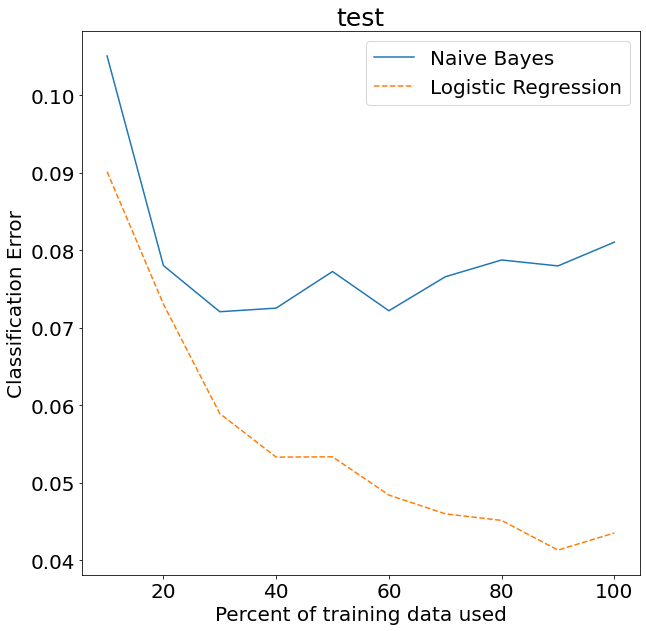

In [21]:
makePlot(tst_errs_nbc, tst_errs_lr, title='test', num_splits=10)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [22]:

# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris = load_iris()
#print(iris)
import pandas as pd
#df = pd.DataFrame(iris)
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])
#data1 = pd.DataFrame(data=iris, index=None, columns=None)
data1.head()



###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [23]:
data1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [24]:
data1.describe()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [26]:
X = data1.drop(columns=['target']).values

y=data1.target.astype(int).values

In [27]:
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(random_state=0, verbose=0)
tst_errs_nbc_std, tst_errs_lr_std = compareNBCvsLR(nbc_iris, lr, X, y, num_runs=800, num_splits=10, standardize_boolean=True)


Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9


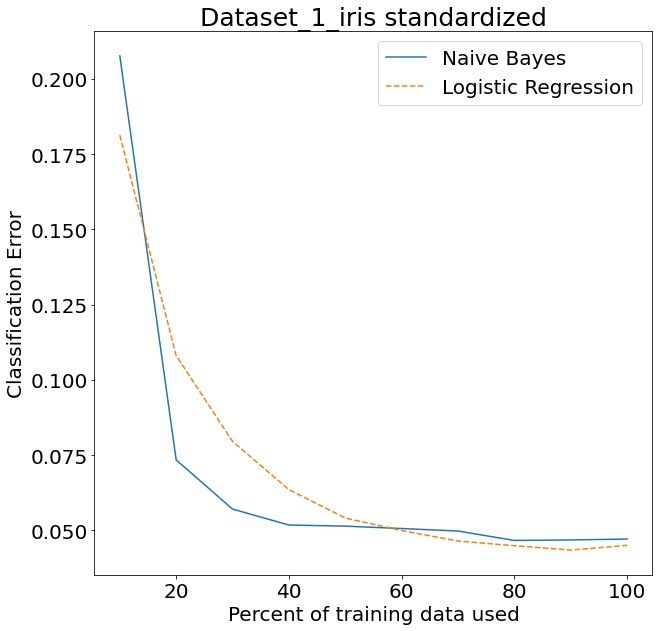

In [28]:
makePlot(tst_errs_nbc_std, tst_errs_lr_std, title='Dataset_1_iris standardized', num_splits=10)

In [29]:
X = data1.drop(columns=['target']).values
y=data1.target.astype(int).values
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(random_state=0, verbose=0)
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_iris, lr, X, y, num_runs=800, num_splits=10, standardize_boolean=False)

Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9


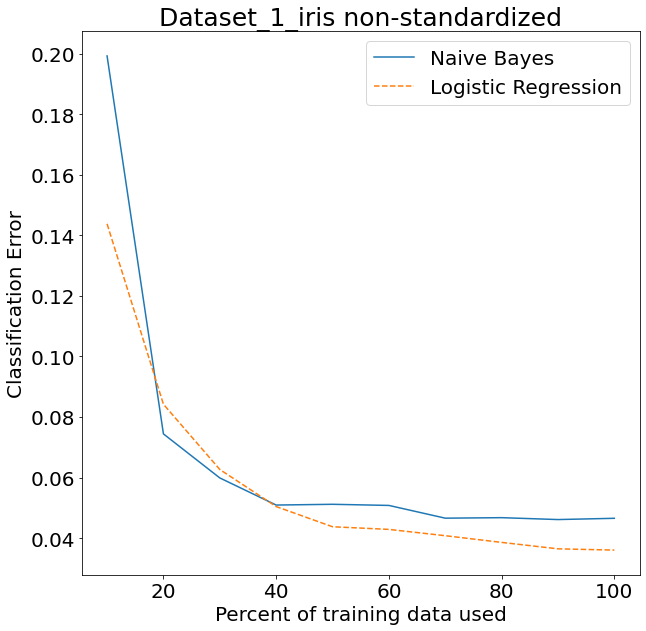

In [30]:
makePlot(tst_errs_nbc, tst_errs_lr, title='Dataset_1_iris non-standardized', num_splits=10)

## Report for dataset 1

For the first dataset I just standardized the data. I decided to standardize in order to see wether or not it has an impact on these two classifiers.

When the dataset is standardized, the Naive Bayes classifier performs a bit better at the beginning. But overall both classifiers have similar results
When the dataset is not standardized, except at the really beginning where the Naive Bayes is better, both classifiers have really smilar results.
In both cases, the more data we use, the smaller the classification error for these two classifiers is.

Because of the standardization I had to make some change in the CompareNBCvsLR. For the small datasets, I had noticed that the shuffler is sometimes not selecting samples for the three classes but only two. As a consequence the classifier is not able to do the predict phase for the class samples that belong to the class that is not included in the training phase. So the modification aims to make sure that the classifier sees the three classes at the training phase.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

In [31]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
#voting = pd.read_csv('./datasets/voting.csv')
voting = pd.read_csv('./voting.csv')


voting.info()
voting.head()
voting.describe()



###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

,label,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,435,423,387,424,424,420,424,421,420,413,428,414,404,410,418,407,331
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


In [32]:
from sklearn import preprocessing


In [33]:
voting = voting.drop("export-administration-act-south-africa", axis=1)

In [34]:
voting = voting.drop("water-project-cost-sharing", axis=1)

In [35]:
voting.columns

Index(['label', 'handicapped-infants', 'adoption-of-the-budget-resolution',
       'physician-fee-freeze', 'el-salvador-aid',
       'religious-groups-in-schools', 'anti-satellite-test-ban',
       'aid-to-nicaraguan-contras', 'mx-missile', 'immigration',
       'synfuels-corporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports'],
      dtype='object')

In [36]:
voting.columns.tolist()

['label',
 'handicapped-infants',
 'adoption-of-the-budget-resolution',
 'physician-fee-freeze',
 'el-salvador-aid',
 'religious-groups-in-schools',
 'anti-satellite-test-ban',
 'aid-to-nicaraguan-contras',
 'mx-missile',
 'immigration',
 'synfuels-corporation-cutback',
 'education-spending',
 'superfund-right-to-sue',
 'crime',
 'duty-free-exports']

In [37]:
for column in voting.columns.tolist():
    voting[column]=voting[column].fillna(voting[column].mode().iloc[0])

In [38]:
for column in voting.columns.tolist():
    le = preprocessing.LabelEncoder()
    le.fit(voting[column])
    voting[column]=le.transform(voting[column])
    
    

In [39]:
voting


,label,handicapped-infants,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
0,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0
1,1,0,0,1,1,1,0,0,0,0,0,1,1,1,0
2,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0
3,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0
4,0,1,1,0,1,1,0,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0
431,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0
432,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0
433,1,0,0,1,1,1,1,1,1,1,0,1,1,1,0


In [40]:
voting.describe()

,label,handicapped-infants,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,0.386207,0.429885,0.606897,0.406897,0.521839,0.650575,0.581609,0.590805,0.526437,0.512644,0.344828,0.393103,0.537931,0.609195,0.400000
std,0.487440,0.495630,0.489002,0.491821,0.500098,0.477337,0.493863,0.492252,0.499876,0.500416,0.475859,0.489002,0.499133,0.488493,0.490462
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
voting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   label                              435 non-null    int32
 1   handicapped-infants                435 non-null    int32
 2   adoption-of-the-budget-resolution  435 non-null    int32
 3   physician-fee-freeze               435 non-null    int32
 4   el-salvador-aid                    435 non-null    int32
 5   religious-groups-in-schools        435 non-null    int32
 6   anti-satellite-test-ban            435 non-null    int32
 7   aid-to-nicaraguan-contras          435 non-null    int32
 8   mx-missile                         435 non-null    int32
 9   immigration                        435 non-null    int32
 10  synfuels-corporation-cutback       435 non-null    int32
 11  education-spending                 435 non-null    int32
 12  superfund-right-to-sue

In [42]:
voting.head()

,label,handicapped-infants,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
0,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0
1,1,0,0,1,1,1,0,0,0,0,0,1,1,1,0
2,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0
3,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0
4,0,1,1,0,1,1,0,0,0,0,1,0,1,1,1


In [43]:
y=voting.label
X=voting.drop(columns=['label']).values


In [44]:
nbc = NBC(feature_types=['b'] * 14)
lr = LogisticRegression(random_state=0)
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y, num_runs=1000, num_splits=10)

Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9


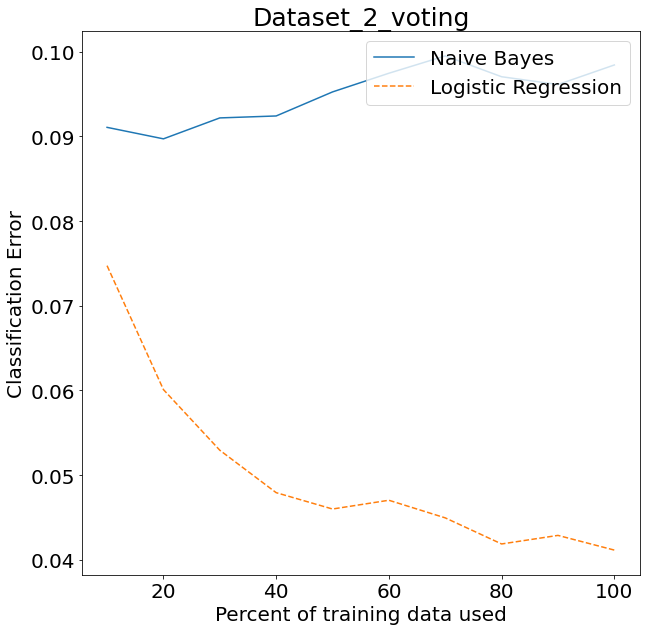

In [45]:
makePlot(tst_errs_nbc, tst_errs_lr, title='Dataset_2_voting', num_splits=10)

In [46]:
voting_2 = voting.sample(n=100)


In [47]:
voting_2.reset_index(inplace=True)

In [48]:
y=voting_2.label
X=voting_2.drop(columns=['label']).values

In [49]:
nbc = NBC(feature_types=['b'] * 14)
lr = LogisticRegression(random_state=0)
tst_errs_nbc_2, tst_errs_lr_2 = compareNBCvsLR(nbc, lr, X, y, num_runs=400, num_splits=20)

Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9
Split: 10
Split: 11
Split: 12
Split: 13
Split: 14
Split: 15
Split: 16
Split: 17
Split: 18
Split: 19


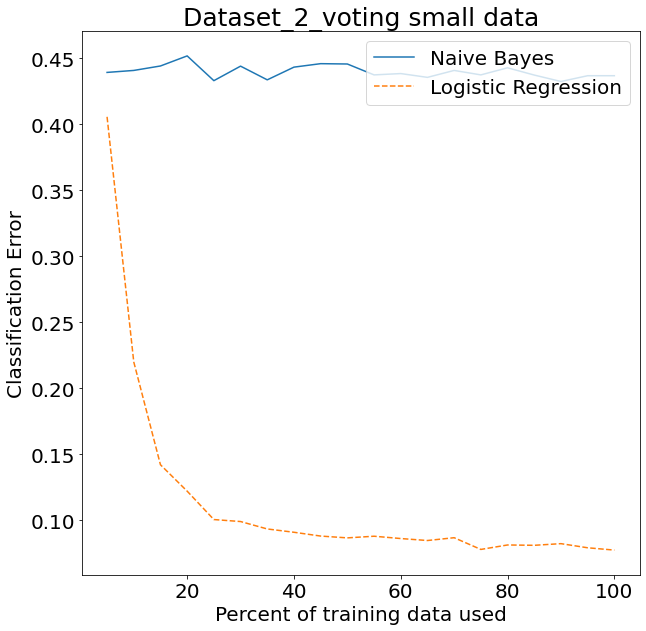

In [50]:
makePlot(tst_errs_nbc_2, tst_errs_lr_2, title='Dataset_2_voting small data', num_splits=20)

In [51]:
y=voting.label
X=voting.drop(columns=['label']).values
nbc = NBC(feature_types=['b'] * 14)
lr = LogisticRegression(random_state=0)
tst_errs_nbc_3, tst_errs_lr_3 = compareNBCvsLR(nbc, lr, X, y, num_runs=300, num_splits=40)

Split: 0
Split: 1
Split: 2
Split: 3
Split: 4
Split: 5
Split: 6
Split: 7
Split: 8
Split: 9
Split: 10
Split: 11
Split: 12
Split: 13
Split: 14
Split: 15
Split: 16
Split: 17
Split: 18
Split: 19
Split: 20
Split: 21
Split: 22
Split: 23
Split: 24
Split: 25
Split: 26
Split: 27
Split: 28
Split: 29
Split: 30
Split: 31
Split: 32
Split: 33
Split: 34
Split: 35
Split: 36
Split: 37
Split: 38
Split: 39


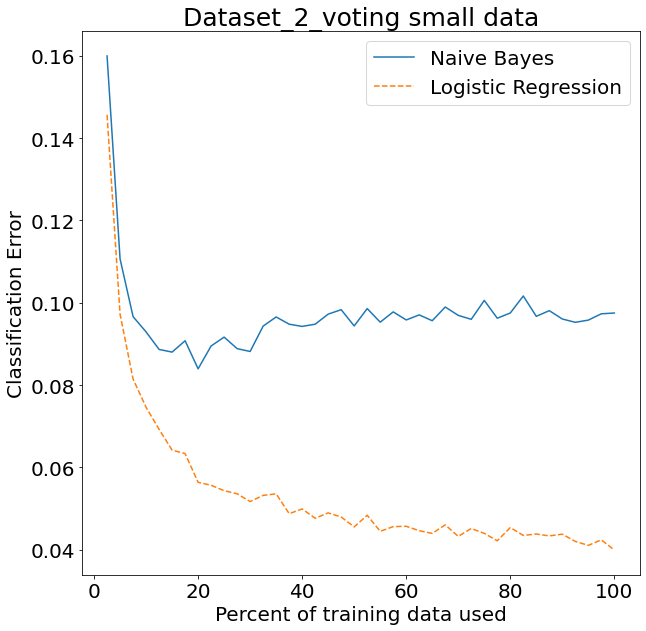

In [52]:
makePlot(tst_errs_nbc_3, tst_errs_lr_3, title='Dataset_2_voting small data', num_splits=40)

# Report dataset 2

For the second dataset I dropped the 2 columns with the most null values. And for the other ones I modified null values to the most common value in the column. I chose this method because I did not want to delete any rows. I also modified all values by 0 or 1 because in all columns there were only 2 possible results

In the first graph with the dataset 2, the Logistic regression classifier is better than the Naive Bayes classifier no matter the percent of training data used. The results of the Naive Bayes classifier remains relatively the same no matter the percent of training data. Whereas for the Logistic Regression classifier the classification error gets lower as we we increase the percent of training data.

In the second graph with the dataset 2 (limited with 100 data points) and 20 splits, the error for Naive Bayes Classifier remains relatively stable no matter the percent of data. Whereas for the Logistic Regression classifier the classification error gets lower really rapidly at the beginning (and is even higher than the Naive bayes at the beginning)  as we we increase the percent of training data.

In the third graph with the entire dataset but with more splits, we can observe something similar to the first graph but with more details. To observe this I increased the number of splits (few points are used to train the model)